# Explore NHANES

This is a first swing at exploring NHANES datasets. Currently just working with the 2021-2023 survey and lumping both days into a single dataset.

An issue that needs to be fixed here is that the grams of PBPs consumed below are based on the total foods/recipes, but are not broken down into what proportion are actually PBPs. Need to add the recipe doc that translates recipes into constituent ingredients and proportions to get proper PBP consumption.

## Set Working Directory

When you open a notebook, the default working directory will be the folder that notebook is in. We want it to be the top (root) directory of the project, 'ds1_nhanes'.

First, we need to mount our Google Drive, which contains the `ds1_nhanes` folder. The following chunk will mount the drive (if in Google Colab) and set the working directory to the root of the project folder.

In [ ]:
import os

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ds1_nhanes/')
except:
  from pathlib import Path
  os.chdir(Path(os.getcwd()).parent)

print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ds1_nhanes


Bingo bongo, we're good to go.

## Load Data and Libraries

In [ ]:
import pandas as pd
import numpy as np

For now we are exploring the 2021-2023 wave dietary recall data for both days:

In [ ]:
dr1 = pd.read_sas('data/raw/nhanes_2021_2023/DR1IFF_L.xpt')
dr2 = pd.read_sas('data/raw/nhanes_2021_2023/DR2IFF_L.xpt')
print(dr1.info())
print(dr2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100116 entries, 0 to 100115
Data columns (total 84 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEQN      100116 non-null  float64
 1   WTDRD1    100116 non-null  float64
 2   WTDR2D    100116 non-null  float64
 3   DR1ILINE  100116 non-null  float64
 4   DR1DRSTZ  100116 non-null  float64
 5   DR1EXMER  100116 non-null  float64
 6   DRABF     99847 non-null   float64
 7   DRDINT    100116 non-null  float64
 8   DR1DBIH   94128 non-null   float64
 9   DR1DAY    100116 non-null  float64
 10  DR1LANG   100025 non-null  float64
 11  DR1CCMNM  100116 non-null  float64
 12  DR1CCMTX  100116 non-null  float64
 13  DR1_020   100116 non-null  float64
 14  DR1_030Z  100116 non-null  float64
 15  DR1FS     92784 non-null   float64
 16  DR1_040Z  99787 non-null   float64
 17  DR1IFDCD  100116 non-null  float64
 18  DR1IGRMS  99787 non-null   float64
 19  DR1IKCAL  99787 non-null   float64
 20  DR1I

## Explore Dietary Recall Data

Compare the dimensions of the df with the number of unique SEQN numbers (respondent ids)

In [ ]:
# Compare rows to unique respondent IDs
# first get number of rows
columns = dr1.shape[0]
unique_seqns = dr1['SEQN'].nunique()
print(f"{columns} columns and {unique_seqns} unique SEQN numbers in DR1.")

100116 columns and 6751 unique SEQN numbers in DR1.


There are far more rows than unique respondents. This is because for each respondent, there is one row for each individual food they consumed.

Check out how many unique food codes there are:

In [ ]:
n_codes = dr1['DR1IFDCD'].nunique()
print(f"There are {n_codes} unique food codes")

There are 3987 unique food codes


### Combine DR1 and DR2

Combine DR1 and DR2 to lump both days into one dataset

In [ ]:
# Make a list of regex patterns to select columns
relevant_cols = ['SEQN','WTDR2D','GRMS$','FDCD$', 'KCAL$', 'PROT$']

# Combine patterns, separate with 'or' operator
pattern = '|'.join(relevant_cols)

# Keep only the selected columns from each DF
dr1 = dr1.loc[:, dr1.columns.str.contains(pattern)]
dr2 = dr2.loc[:, dr2.columns.str.contains(pattern)]

# Check column names
print(dr1.columns)
print(dr2.columns)

Index(['SEQN', 'WTDR2D', 'DR1IFDCD', 'DR1IGRMS', 'DR1IKCAL', 'DR1IPROT'], dtype='object')
Index(['SEQN', 'WTDR2D', 'DR2IFDCD', 'DR2IGRMS', 'DR2IKCAL', 'DR2IPROT'], dtype='object')


In [ ]:
# Check SEQNs between dr1 and dr2
diff = set(dr1['SEQN']).difference(dr2['SEQN'])
print(f"{len(diff)} SEQNs missing from DR2 that were in DR1")
diff2 = set(dr2['SEQN']).difference(dr1['SEQN'])
print(f"{len(diff2)} SEQNs missing from DR1 that were in DR2")

873 SEQNs missing from DR2 that were in DR1
1 SEQNs missing from DR1 that were in DR2


Losing 873 people when we join, but the day 2 weights should account for that

Now merge dr1 and dr2

In [ ]:
df = dr1.merge(dr2, on='SEQN', how='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424104 entries, 0 to 1424103
Data columns (total 11 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   SEQN      1424104 non-null  float64
 1   WTDR2D_x  1424104 non-null  float64
 2   DR1IFDCD  1424104 non-null  float64
 3   DR1IGRMS  1420522 non-null  float64
 4   DR1IKCAL  1420522 non-null  float64
 5   DR1IPROT  1420522 non-null  float64
 6   WTDR2D_y  1424104 non-null  float64
 7   DR2IFDCD  1424104 non-null  float64
 8   DR2IGRMS  1420862 non-null  float64
 9   DR2IKCAL  1420862 non-null  float64
 10  DR2IPROT  1420862 non-null  float64
dtypes: float64(11)
memory usage: 119.5 MB


In [ ]:
df['SEQN'].duplicated().sum()  # Check for duplicates in df1


np.int64(1418226)

Looks like both datasets have a 2 day weight, and they should be the same. So let's get rid of one

In [ ]:
df = df.drop(columns='WTDR2D_y')
df = df.rename(columns={'WTDR2D_x': 'WTDR2D'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424104 entries, 0 to 1424103
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   SEQN      1424104 non-null  float64
 1   WTDR2D    1424104 non-null  float64
 2   DR1IFDCD  1424104 non-null  float64
 3   DR1IGRMS  1420522 non-null  float64
 4   DR1IKCAL  1420522 non-null  float64
 5   DR1IPROT  1420522 non-null  float64
 6   DR2IFDCD  1424104 non-null  float64
 7   DR2IGRMS  1420862 non-null  float64
 8   DR2IKCAL  1420862 non-null  float64
 9   DR2IPROT  1420862 non-null  float64
dtypes: float64(10)
memory usage: 108.7 MB


## Add Demographics

Load demographic data as xpt:

In [ ]:
demos = pd.read_sas('data/raw/nhanes_2021_2023/DEMO_L.xpt')
demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      11933 non-null  float64
 1   SDDSRVYR  11933 non-null  float64
 2   RIDSTATR  11933 non-null  float64
 3   RIAGENDR  11933 non-null  float64
 4   RIDAGEYR  11933 non-null  float64
 5   RIDAGEMN  377 non-null    float64
 6   RIDRETH1  11933 non-null  float64
 7   RIDRETH3  11933 non-null  float64
 8   RIDEXMON  8860 non-null   float64
 9   RIDEXAGM  2787 non-null   float64
 10  DMQMILIZ  8301 non-null   float64
 11  DMDBORN4  11914 non-null  float64
 12  DMDYRUSR  1875 non-null   float64
 13  DMDEDUC2  7794 non-null   float64
 14  DMDMARTZ  7792 non-null   float64
 15  RIDEXPRG  1503 non-null   float64
 16  DMDHHSIZ  11933 non-null  float64
 17  DMDHRGND  4115 non-null   float64
 18  DMDHRAGZ  4124 non-null   float64
 19  DMDHREDZ  3746 non-null   float64
 20  DMDHRMAZ  4020 non-null   fl

Take the columns SEQN, age, gender, race, education, and ratio of family income to poverty:

In [ ]:
demos = demos[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDEDUC2', 'INDFMPIR']]
demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      11933 non-null  float64
 1   RIAGENDR  11933 non-null  float64
 2   RIDAGEYR  11933 non-null  float64
 3   RIDRETH3  11933 non-null  float64
 4   DMDEDUC2  7794 non-null   float64
 5   INDFMPIR  9892 non-null   float64
dtypes: float64(6)
memory usage: 559.5 KB


Merge demographics with our dr1 data frame:

In [ ]:
# Now join our demos with our DR1 data
df = df.merge(demos, on='SEQN', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424104 entries, 0 to 1424103
Data columns (total 15 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   SEQN      1424104 non-null  float64
 1   WTDR2D    1424104 non-null  float64
 2   DR1IFDCD  1424104 non-null  float64
 3   DR1IGRMS  1420522 non-null  float64
 4   DR1IKCAL  1420522 non-null  float64
 5   DR1IPROT  1420522 non-null  float64
 6   DR2IFDCD  1424104 non-null  float64
 7   DR2IGRMS  1420862 non-null  float64
 8   DR2IKCAL  1420862 non-null  float64
 9   DR2IPROT  1420862 non-null  float64
 10  RIAGENDR  1424104 non-null  float64
 11  RIDAGEYR  1424104 non-null  float64
 12  RIDRETH3  1424104 non-null  float64
 13  DMDEDUC2  1132657 non-null  float64
 14  INDFMPIR  1274465 non-null  float64
dtypes: float64(15)
memory usage: 163.0 MB


## Create Variables from FPED

To identify the foods from food codes, we join with the Food Patterns Equivalents Database (FPED). This links it to the ~39 USDA food categories that correspond to national dietary recommendations. It also converts from sensible units like grams to American units like cups.

In [ ]:
fped = pd.read_csv('data/miscellany/FPED_1720.csv')
fped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7444 entries, 0 to 7443
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   FOODCODE                   7444 non-null   int64  
 1   DESCRIPTION                7444 non-null   object 
 2   F_TOTAL (cup eq)           7444 non-null   float64
 3   F_CITMLB (cup eq)          7444 non-null   float64
 4   F_OTHER (cup eq)           7444 non-null   float64
 5   F_JUICE (cup eq)           7444 non-null   float64
 6   V_TOTAL (cup eq)           7444 non-null   float64
 7   V_DRKGR (cup eq)           7444 non-null   float64
 8   V_REDOR_TOTAL (cup eq)     7444 non-null   float64
 9   V_REDOR_TOMATO (cup eq)    7444 non-null   float64
 10  V_REDOR_OTHER (cup eq)     7444 non-null   float64
 11  V_STARCHY_TOTAL (cup eq)   7444 non-null   float64
 12  V_STARCHY_POTATO (cup eq)  7444 non-null   float64
 13  V_STARCHY_OTHER (cup eq)   7444 non-null   float

Get the column names which identify food codes as containing any amount of legumes, nuts/seeds, or soy:

In [ ]:
# Keywords we will use to find column names
keywords = ['PF_LEGUMES', 'PF_NUTSDS', 'PF_SOY']
pbp_columns = [col for col in fped.columns if any(keyword in col for keyword in keywords)]
print(pbp_columns)

['PF_SOY (oz eq)', 'PF_NUTSDS (oz eq)', 'PF_LEGUMES (oz eq)']


Now identify the food codes that are PBPs:

In [ ]:
# Condition is that any one of those columns says the food code has some amount of it
condition = (fped[pbp_columns] > 0).any(axis=1)

# Filter by the condition
pbp_codes = fped.loc[condition, 'FOODCODE']

# Print number of unique codes
n_codes = len(pbp_codes)
print(f'There are {n_codes} unique PBP food codes')

There are 800 unique PBP food codes


Make a column that identifies whether foods are PBPs or not:

In [ ]:
df['is_pbp'] = df['DR1IFDCD'].isin(pbp_codes).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424104 entries, 0 to 1424103
Data columns (total 16 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   SEQN      1424104 non-null  float64
 1   WTDR2D    1424104 non-null  float64
 2   DR1IFDCD  1424104 non-null  float64
 3   DR1IGRMS  1420522 non-null  float64
 4   DR1IKCAL  1420522 non-null  float64
 5   DR1IPROT  1420522 non-null  float64
 6   DR2IFDCD  1424104 non-null  float64
 7   DR2IGRMS  1420862 non-null  float64
 8   DR2IKCAL  1420862 non-null  float64
 9   DR2IPROT  1420862 non-null  float64
 10  RIAGENDR  1424104 non-null  float64
 11  RIDAGEYR  1424104 non-null  float64
 12  RIDRETH3  1424104 non-null  float64
 13  DMDEDUC2  1132657 non-null  float64
 14  INDFMPIR  1274465 non-null  float64
 15  is_pbp    1424104 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 173.8 MB


In [ ]:
# Make another new column that just multiplies grams by is_bpl
# so it is 0 if not bpl, or the number of grams if it is
df['grams_pbp_d1'] = np.where(df['is_pbp'] == True, df['DR1IGRMS'], 0)
df['grams_pbp_d2'] = np.where(df['is_pbp'] == True, df['DR2IGRMS'], 0)
df['grams_pbp_total'] = df['grams_pbp_d1'] + df['grams_pbp_d2']
print(df.columns)
print(df.shape)

Index(['SEQN', 'WTDR2D', 'DR1IFDCD', 'DR1IGRMS', 'DR1IKCAL', 'DR1IPROT',
       'DR2IFDCD', 'DR2IGRMS', 'DR2IKCAL', 'DR2IPROT', 'RIAGENDR', 'RIDAGEYR',
       'RIDRETH3', 'DMDEDUC2', 'INDFMPIR', 'is_pbp', 'grams_pbp_d1',
       'grams_pbp_d2', 'grams_pbp_total'],
      dtype='object')
(1424104, 19)


Group the dietary recall data by SEQN to get totals of consumption for each person. Also creating variables for the proportion of consumption (grams) of PBPs out of total consumption (grams) for the day:

In [ ]:
# Group by SEQN to get summary stats for consumption of each person
# For grams, we are adding up the sums of total and bpl grams
# For everything else, just take first value because it should be same among everyone
# Would have been easier to just make smaller DF and then join it.
# But this already happened
dat = df.groupby('SEQN').agg(
  weight_2d=('WTDR2D', 'first'),
  grams_d1=('DR1IGRMS', 'sum'),
  grams_d2=('DR2IGRMS', 'sum'),
  pbp_grams_d1=('grams_pbp_d1', 'sum'),
  pbp_grams_d2=('grams_pbp_d2', 'sum'),
  age=('RIDAGEYR', 'first'),
  gender=('RIAGENDR', 'first'),
  education=('DMDEDUC2', 'first'),
  race=('RIDRETH3', 'first'),
  income_ratio=('INDFMPIR', 'first')
)

# Add total grams, total pbp grams
dat['total_grams'] = dat['grams_d1'] + dat['grams_d2']
dat['total_pbp_grams'] = dat['pbp_grams_d1'] + dat['pbp_grams_d2']

# One more thing - percentage of bpl grams to total grams for each person
dat['prop_grams_from_pbp'] = dat['total_pbp_grams'] / dat['total_grams']
print(dat.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5878 entries, 130378.0 to 142310.0
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   weight_2d            5878 non-null   float64
 1   grams_d1             5878 non-null   float64
 2   grams_d2             5878 non-null   float64
 3   pbp_grams_d1         5878 non-null   float64
 4   pbp_grams_d2         5878 non-null   float64
 5   age                  5878 non-null   float64
 6   gender               5878 non-null   float64
 7   education            4284 non-null   float64
 8   race                 5878 non-null   float64
 9   income_ratio         5212 non-null   float64
 10  total_grams          5878 non-null   float64
 11  total_pbp_grams      5878 non-null   float64
 12  prop_grams_from_pbp  5871 non-null   float64
dtypes: float64(13)
memory usage: 642.9 KB
None


Recode demographic variables. Coding schemes are available at the NHANES website in the documentation beside each dataset. We are splitting the income to poverty ratio into quartiles.

In [ ]:
# Gender
dat['gender'] = dat['gender'].apply(lambda x: ('Female' if x == 2 else 'Male'))

# Education
dat['education'] = dat['education'].apply(
  lambda x: (
    'Less than 9th grade' if x == 1
    else '9th to 11th grade' if x == 2
    else 'High school/GED' if x == 3
    else 'Some college or AA' if x == 4
    else 'College graduate or above' if x == 5
    else "Don\'t know"
  )
)

# Race
dat['race'] = dat['race'].apply(
  lambda x: (
    'Mexican American' if x == 1
    else 'Other Hispanic' if x == 2
    else 'White' if x == 3
    else 'Black' if x == 4
    else 'Asian' if x == 5
    else 'Other or Multi'
  )
)

# Income to poverty ratio
dat['income_ratio_qs'] = pd.qcut(
  x = dat['income_ratio'],
  q = 4,
  duplicates='drop'
)
dat.head()

,weight_2d,grams_d1,grams_d2,pbp_grams_d1,pbp_grams_d2,age,gender,education,race,income_ratio,total_grams,total_pbp_grams,prop_grams_from_pbp,income_ratio_qs
SEQN,,,,,,,,,,,,,,
130378.0,70554.222162,36620.80,37284.40,0.0,0.00,43.0,Male,College graduate or above,Other or Multi,5.00,73905.20,0.00,0.000000,"(4.92, 5.0]"
130379.0,36505.468348,93959.00,87899.91,0.0,0.00,66.0,Male,College graduate or above,White,5.00,181858.91,0.00,0.000000,"(4.92, 5.0]"
130380.0,103979.190677,72600.00,71622.72,0.0,0.00,44.0,Female,High school/GED,Other Hispanic,1.41,144222.72,0.00,0.000000,"(1.34, 2.77]"
130381.0,75009.220819,33921.80,25796.82,195.5,1228.42,5.0,Female,Don't know,Other or Multi,1.53,59718.62,1423.92,0.023844,"(1.34, 2.77]"
130382.0,172361.851828,16873.78,27986.94,1232.0,1554.83,2.0,Male,Don't know,White,3.60,44860.72,2786.83,0.062122,"(2.77, 4.92]"


This is our cleanish data for exploratory stuff. Note that we are only looking at day 1, which is not the ultimate plan. NHANES recommends using both days and combining at least 2 waves of data for a cross-sectional study.

In [ ]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5878 entries, 130378.0 to 142310.0
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   weight_2d            5878 non-null   float64 
 1   grams_d1             5878 non-null   float64 
 2   grams_d2             5878 non-null   float64 
 3   pbp_grams_d1         5878 non-null   float64 
 4   pbp_grams_d2         5878 non-null   float64 
 5   age                  5878 non-null   float64 
 6   gender               5878 non-null   object  
 7   education            5878 non-null   object  
 8   race                 5878 non-null   object  
 9   income_ratio         5212 non-null   float64 
 10  total_grams          5878 non-null   float64 
 11  total_pbp_grams      5878 non-null   float64 
 12  prop_grams_from_pbp  5871 non-null   float64 
 13  income_ratio_qs      5212 non-null   category
dtypes: category(1), float64(10), object(3)
memory usage: 648.9+ KB


Let's also save this as a csv so we can play around with it elsewhere:

In [ ]:
dat.to_csv('data/clean/dr1_data_2021_2023.csv')

## Graphs

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Set a common theme for our plots:

In [ ]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (6, 6)
}
sns.set_theme(style="ticks", rc=custom_params)

PBP consumption by gender. Note that we are using the 2-day weights

In [ ]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5878 entries, 130378.0 to 142310.0
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   weight_2d            5878 non-null   float64 
 1   grams_d1             5878 non-null   float64 
 2   grams_d2             5878 non-null   float64 
 3   pbp_grams_d1         5878 non-null   float64 
 4   pbp_grams_d2         5878 non-null   float64 
 5   age                  5878 non-null   float64 
 6   gender               5878 non-null   object  
 7   education            5878 non-null   object  
 8   race                 5878 non-null   object  
 9   income_ratio         5212 non-null   float64 
 10  total_grams          5878 non-null   float64 
 11  total_pbp_grams      5878 non-null   float64 
 12  prop_grams_from_pbp  5871 non-null   float64 
 13  income_ratio_qs      5212 non-null   category
dtypes: category(1), float64(10), object(3)
memory usage: 648.9+ KB


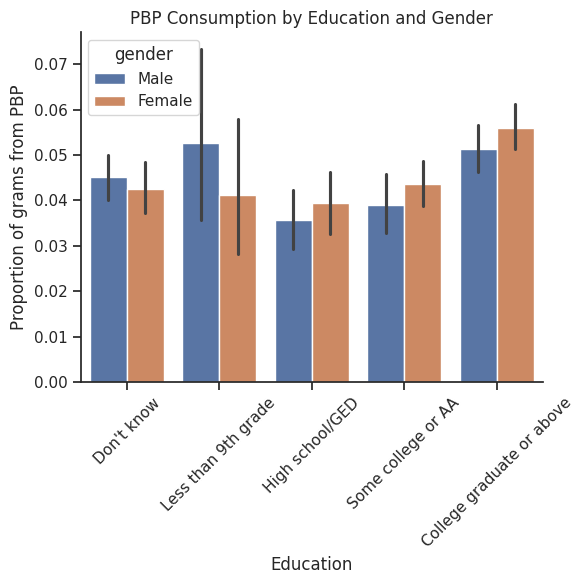

In [ ]:
# pbp consumption by gender
ax = sns.barplot(
  data=dat,
  y='prop_grams_from_pbp',
  x='education',
  hue='gender',
  order=[
    "Don't know",
    'Less than 9th grade',
    'High school/GED',
    'Some college or AA',
    'College graduate or above'
  ],
  weights='weight_2d',
  errorbar=('ci', 95)
)
ax.set(
  ylabel = 'Proportion of grams from PBP',
  xlabel = 'Education',
  title = 'PBP Consumption by Education and Gender'
)
plt.xticks(rotation=45)

# Save plot
plt.tight_layout()
plt.savefig('outputs/checkin_1/pbp_consumption_by_education.png')

plt.show()
# Would like to adjust names horizontally to line up better after rotation, hjust arg?

Let's see what happens if we make the same graph without survey weights:

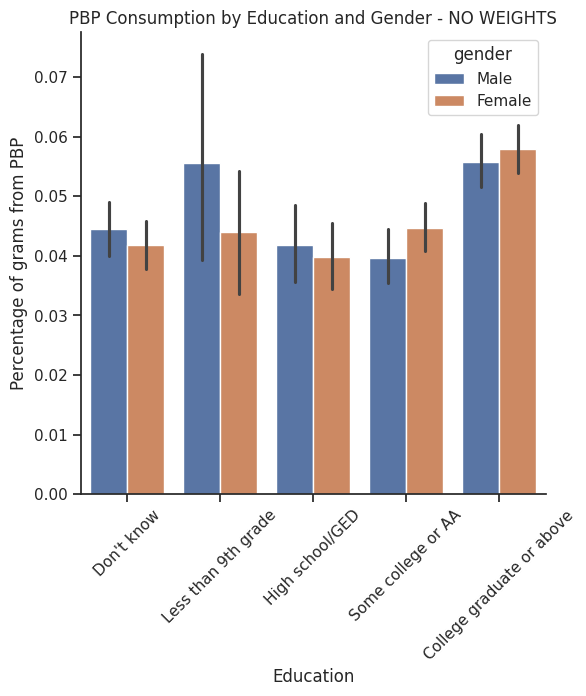

In [ ]:
# pbp consumption by gender
ax = sns.barplot(
  data=dat,
  y='prop_grams_from_pbp',
  x='education',
  hue='gender',
  order=[
    "Don't know",
    'Less than 9th grade',
    'High school/GED',
    'Some college or AA',
    'College graduate or above'
  ],
  # weights='weight_2d',
  errorbar=('ci', 95)
)
ax.set(
  ylabel = 'Percentage of grams from PBP',
  xlabel = 'Education',
  title = 'PBP Consumption by Education and Gender - NO WEIGHTS'
)
plt.xticks(rotation=45)
plt.show()
# Would like to adjust names horizontally to line up better after rotation, hjust arg?

Observe. It is different.

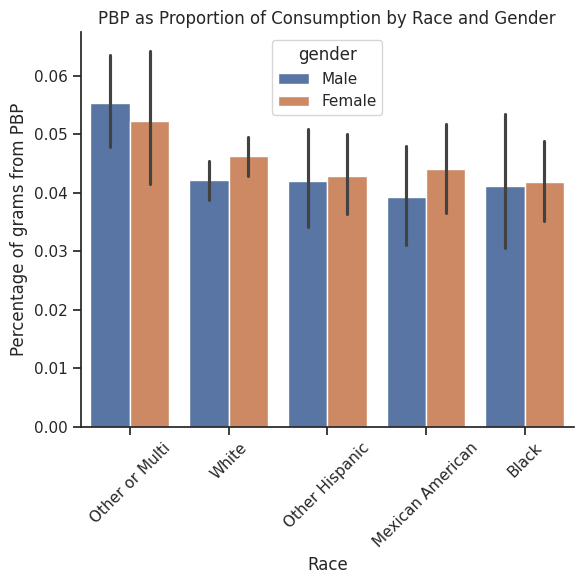

In [ ]:
# pbp consumption by race
ax = sns.barplot(
  data=dat,
  y='prop_grams_from_pbp',
  x='race',
  hue='gender',
  weights='weight_2d',
  errorbar=('ci', 95)
)
ax.set(
  xlabel = 'Race',
  ylabel = 'Percentage of grams from PBP',
  title = 'PBP as Proportion of Consumption by Race and Gender'
)
plt.xticks(rotation=45)
plt.tight_layout()

# Save it
plt.savefig('outputs/checkin_1/pbp_consumption_by_race.png')

# Show it
plt.show()

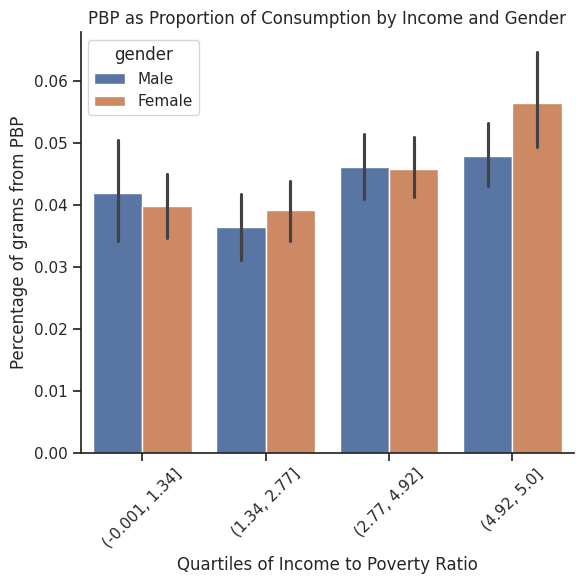

In [ ]:
# pbp consumption by poverty ratio
ax = sns.barplot(
  data=dat,
  y='prop_grams_from_pbp',
  x='income_ratio_qs',
  hue='gender',
  weights='weight_2d',
  errorbar=('ci', 95)
)
ax.set(
  xlabel = 'Quartiles of Income to Poverty Ratio',
  ylabel = 'Percentage of grams from PBP',
  title = 'PBP as Proportion of Consumption by Income and Gender'
)
plt.xticks(rotation=45)
plt.tight_layout()

# Save it
plt.savefig('outputs/checkin_1/pbp_consumption_by_income.png')

# Show it
plt.show()

## Test a Table

Just figuring out how to make a LaTeX table

In [ ]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5878 entries, 130378.0 to 142310.0
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   weight_2d            5878 non-null   float64 
 1   grams_d1             5878 non-null   float64 
 2   grams_d2             5878 non-null   float64 
 3   pbp_grams_d1         5878 non-null   float64 
 4   pbp_grams_d2         5878 non-null   float64 
 5   age                  5878 non-null   float64 
 6   gender               5878 non-null   object  
 7   education            5878 non-null   object  
 8   race                 5878 non-null   object  
 9   income_ratio         5212 non-null   float64 
 10  total_grams          5878 non-null   float64 
 11  total_pbp_grams      5878 non-null   float64 
 12  prop_grams_from_pbp  5871 non-null   float64 
 13  income_ratio_qs      5212 non-null   category
dtypes: category(1), float64(10), object(3)
memory usage: 648.9+ KB


In [ ]:
# Make a smaller DF to play around with
small_df = dat.head().iloc[:, :4]
print(small_df)

              weight_2d  grams_d1  grams_d2  pbp_grams_d1
SEQN                                                     
130378.0   70554.222162  36620.80  37284.40           0.0
130379.0   36505.468348  93959.00  87899.91           0.0
130380.0  103979.190677  72600.00  71622.72           0.0
130381.0   75009.220819  33921.80  25796.82         195.5
130382.0  172361.851828  16873.78  27986.94        1232.0


In [ ]:
# Rename columns to ditch underscores
small_df.columns = ['2 Day Weight', 'Grams Day 1', 'Grams Day 2', 'PBP Grams Day 1']
print(small_df)

           2 Day Weight  Grams Day 1  Grams Day 2  PBP Grams Day 1
SEQN                                                              
130378.0   70554.222162     36620.80     37284.40              0.0
130379.0   36505.468348     93959.00     87899.91              0.0
130380.0  103979.190677     72600.00     71622.72              0.0
130381.0   75009.220819     33921.80     25796.82            195.5
130382.0  172361.851828     16873.78     27986.94           1232.0


In [ ]:
small_df.to_latex(
  'outputs/checkin_1/test_table.tex',
  index=False,
  float_format="%.2f",
  label='test_table',
  caption='This is a test table',
  position='h'
)


Looks like this mostly works. Could use some proper formatting though